In [577]:
# Cloning repository with the data for the experiment
# data -> thermalImagesClassificatoin/data/ ...

!git clone https://github.com/rgmantovani/thermalImagesClassification.git

fatal: destination path 'thermalImagesClassification' already exists and is not an empty directory.


In [578]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2 #opencv in pyhton
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [579]:
# For help: https://github.com/ribeiro-julio/crop-image-classification/blob/main/scripts/04_running_CNN.py

from tensorflow.keras import layers, models
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [580]:
SEEDS = [51, 171, 666, 404, 42]
current_seed = SEEDS[4]
# ----------------------------
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) `tensorflow` random seed
# 3) `python` random seed
# ----------------------------
keras.utils.set_random_seed(current_seed)

In [581]:
# data directory
health_dir = "/content/thermalImagesClassification/data/saudaveis"
osteo_dir  = "/content/thermalImagesClassification/data/diagnosticos"

# constant for experiment
num_classes = 2

In [582]:
TYPE_OF_IMAGE = "raw"
# TYPE_OF_IMAGE = "rgb"
# TYPE_OF_IMAGE = "gray"

In [583]:
# loading filepaths
csv_files_health = glob.glob(os.path.join(health_dir, "**","*.csv"),recursive=True)
csv_files_osteo  = glob.glob(os.path.join(osteo_dir, "**", "*.csv"),recursive=True)

In [584]:
raw_file = csv_files_health[0]
print(raw_file)

/content/thermalImagesClassification/data/saudaveis/tibia_em_pe/Em_pe_135.csv


In [585]:
# ----------------------------------------------------------------------------
# Creating labels
# ----------------------------------------------------------------------------
Y_healthy = np.zeros(len(csv_files_health))
Y_osteo  = np.ones(len(csv_files_osteo))

# concatenating values
Y = np.concatenate((Y_healthy, Y_osteo))
print(Y)

# ----------------------------------------------------------------------------
# ----------------------------------------------------------------------------

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [586]:
# --------------------------------------------------------------
# Splitting files into training and testing folds
# --------------------------------------------------------------
all_files = csv_files_health + csv_files_osteo

x_train_files, x_test_files, y_train, y_test = train_test_split(all_files,
    Y, test_size=0.3, random_state=42, stratify=Y)

In [587]:
print("Tamanho do X_train:", len(x_train_images))
print("Tamanho do X_test:", len(x_test_images))
print("Tamanho do y_train:", y_train.shape)
print("Tamanho do y_test:", y_test.shape)

Tamanho do X_train: 511
Tamanho do X_test: 220
Tamanho do y_train: (511,)
Tamanho do y_test: (220,)


In [588]:
# --------------------------------------------------------------
# function to plot thermal imagens from raw file
# --------------------------------------------------------------

def plot_csv_image(csv_file):
    data = pd.read_csv(csv_file, header=None)
    image_array = data.to_numpy()
    plt.imshow(image_array, cmap='inferno', interpolation='nearest')
    plt.colorbar()
    plt.show()

# --------------------------------------------------------------
# --------------------------------------------------------------

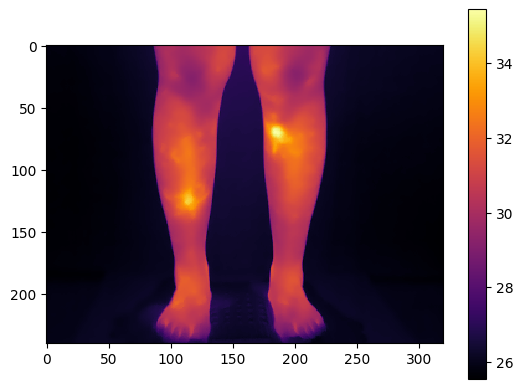

/content/thermalImagesClassification/data/saudaveis/tibia_em_pe/Em_pe_253.csv
0.0


In [589]:
# plot_csv_image(csv_file=x_train_files[0])
plot_csv_image(csv_file=x_test_files[0])
print(x_test_files[0])
print(y_test[0])

In [590]:
# --------------------------------------------------------------
# function to load thermal images from csv files
# --------------------------------------------------------------

def load_images_from_csv_files(csv_files):
  if not csv_files:
    raise Exception("No *.csv file was found.")

  raw_images = [pd.read_csv(file).to_numpy() for file in csv_files]
  return(raw_images)

# --------------------------------------------------------------
# --------------------------------------------------------------

In [591]:
# --------------------------------------------------------------
# reading images from files
# --------------------------------------------------------------

x_train_images = load_images_from_csv_files(csv_files=x_train_files)
print(x_train_images[0].shape)

x_test_images = load_images_from_csv_files(csv_files=x_test_files)
print(x_test_images[0].shape)


(239, 320)
(239, 320)


In [592]:
df = pd.DataFrame(x_train_images[0])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,310,311,312,313,314,315,316,317,318,319
0,17.34129,17.32995,17.31860,17.31292,17.30725,17.30157,17.30157,17.2959,17.29022,17.27887,...,16.72663,16.72663,16.73234,16.72663,16.72092,16.72092,16.72092,16.72663,16.72663,16.72663
1,17.34129,17.32995,17.31292,17.31292,17.31292,17.31292,17.30157,17.2959,17.29022,17.27319,...,16.72663,16.73234,16.72663,16.73234,16.72092,16.72663,16.72663,16.72663,16.72092,16.72663
2,17.34129,17.32995,17.31860,17.31860,17.31292,17.31292,17.30725,17.2959,17.29022,17.27887,...,16.72092,16.72663,16.73234,16.73234,16.72663,16.73234,16.73234,16.72092,16.72092,16.72663
3,17.34129,17.33562,17.32427,17.31292,17.31860,17.31292,17.30725,17.2959,17.29022,17.27887,...,16.73234,16.72663,16.72663,16.72663,16.73234,16.73234,16.72663,16.72663,16.72663,16.72663
4,17.34697,17.33562,17.32427,17.31860,17.31860,17.31292,17.30725,17.2959,17.29022,17.27887,...,16.73234,16.73234,16.72663,16.73234,16.73805,16.73805,16.73234,16.72663,16.72663,16.72663


In [593]:
# Min and Max temperature values in the raw image
selected_id = 50
print("Image: ", x_train_files[selected_id])
print("Min value: ", np.min(x_train_images[selected_id]))
print("Max value: ", np.max(x_train_images[selected_id]))
print("Mean: ", np.mean(x_train_images[selected_id]))

Image:  /content/thermalImagesClassification/data/diagnosticos/pseudoartrose/pseudoartrose_de_tibia/pessoa17/pessoa17_avaliacao01.csv
Min value:  24.86108
Max value:  33.56013
Mean:  28.45278599751569


In [594]:
# --------------------------------------------------------------
# normalize image withing [min, max] range
# --------------------------------------------------------------

def normalize(image):
    max = np.amax(image)
    min = np.amin(image)
    normalized_image = (image-min)/(max - min)
    return (normalized_image)

In [595]:
# -----------------------------------------------
# -----------------------------------------------

def thermal_to_rgb_image(image):
  norm_img = normalize(image = image)
  new_img  = np.round(norm_img * 255)
  u8 = new_img.astype(np.uint8)
  im_color = cv2.applyColorMap(u8, cv2.COLORMAP_JET)
  return(im_color)

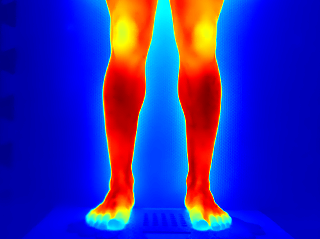

In [596]:
# example of RGB healthy image
imgc = thermal_to_rgb_image(image = x_train_images[2])
cv2_imshow(imgc)

In [597]:
imgc.shape

(239, 320, 3)

In [598]:
# converting all healthy thermal raw images to RGB

if(TYPE_OF_IMAGE == "rgb"):
  print("* Converting thermal images to RGB")
  new_x_train_images = [thermal_to_rgb_image(x) for x in x_train_images]
  new_x_test_images  = [thermal_to_rgb_image(x) for x in x_test_images]
  input_shape = (239, 320, 3)
else:
  print ("* Using raw images - normalized between [0, 1]")
  new_x_train_images = [normalize(x) for x in x_train_images]
  new_x_test_images  = [normalize(x) for x in x_test_images]
  input_shape = (239, 320, 1)
  print(new_x_train_images[0])

# Elif(TYPE_OF_IMAGE == "grey"):
#   print(* Converting theraml images to grey scale)
  # new_x_train_images = [thermal_to_grey_image(x) for x in x_train_images]
  # new_x_test_images  = [thermal_to_grey_image(x) for x in x_test_images]

* Using raw images - normalized between [0, 1]
[[0.0418969  0.04126492 0.04063238 ... 0.00764173 0.00764173 0.00764173]
 [0.0418969  0.04126492 0.04031583 ... 0.00764173 0.00732351 0.00764173]
 [0.0418969  0.04126492 0.04063238 ... 0.00732351 0.00732351 0.00764173]
 ...
 [0.06618806 0.06776132 0.06839052 ... 0.01622587 0.01654353 0.01686119]
 [0.06461367 0.0655583  0.06650237 ... 0.01622587 0.01622587 0.01654353]
 [0.06146436 0.06303929 0.06398392 ... 0.01559054 0.01559054 0.01590821]]


In [599]:
# -------------------------------------------
# Creating Training Dataset
# -------------------------------------------
X_train = np.array(new_x_train_images)
X_test  = np.array(new_x_test_images)

In [600]:
# convert values to the inverval [0, 1]
if(TYPE_OF_IMAGE != "raw"):
  X_train = X_train.astype("float32") / 255
  X_test = X_test.astype("float32") / 255

In [601]:
# ------------------------------------------------------------
# ------------------------------------------------------------

# TODO: balanceamento no conjunto de treinamento
# Data augmentation da classe minoritaria (quais operacoes)
# usar data augmentation -> https://albumentations.ai/

# ------------------------------------------------------------
# ------------------------------------------------------------

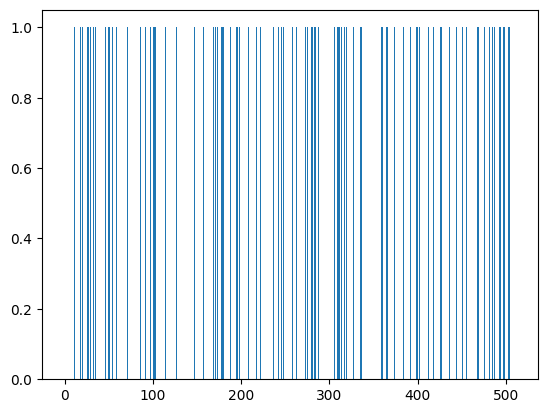

In [602]:
# print(y_test)
plt.bar(np.arange(len(y_train)),y_train)
plt.show()

In [603]:
# Classical CNN architecture
def get_CNN_model(input_shape):

	CNNmodel = models.Sequential()
	CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
	CNNmodel.add(layers.MaxPooling2D((2, 2)))
	CNNmodel.add(layers.Dropout(0.25))
	CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
	CNNmodel.add(layers.MaxPooling2D((2, 2)))
	CNNmodel.add(layers.Dropout(0.25))
	CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
	CNNmodel.add(layers.Flatten())
	CNNmodel.add(layers.Dense(64, activation='relu'))
	CNNmodel.add(layers.Dropout(0.5))
	CNNmodel.add(layers.Dense(1, activation="sigmoid"))

	return(CNNmodel)

In [604]:
# Defining a classical CNN model
model = get_CNN_model(input_shape=input_shape)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 237, 318, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 118, 159, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 118, 159, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 116, 157, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 58, 78, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 58, 78, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 56, 76, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 272384)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │    17,432,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,488,449 (66.71 MB)

 Trainable params: 17,488,449 (66.71 MB)

 Non-trainable params: 0 (0.00 B)

In [605]:
model.compile(
    optimizer='adam',
    loss=BinaryCrossentropy(),
    metrics=['binary_accuracy', 'accuracy']
)

In [606]:
# ----------------------------
# Traninig the algorithm
# ----------------------------

# Callbacks
early_stopper = EarlyStopping(monitor="val_loss", mode="min", patience=10, verbose=1)
csv_logger    = CSVLogger(f"log_history_cnn_{TYPE_OF_IMAGE}_seed_{current_seed}.csv", separator=",", append=False)

print(" - training CNN")

history  = model.fit(X_train, y_train, epochs=100, validation_split=0.3, batch_size=16, callbacks=[early_stopper, csv_logger])

 - training CNN
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 0.6135 - binary_accuracy: 0.6135 - loss: 1.7953 - val_accuracy: 0.7727 - val_binary_accuracy: 0.7727 - val_loss: 0.4606
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7508 - binary_accuracy: 0.7508 - loss: 0.4359 - val_accuracy: 0.8636 - val_binary_accuracy: 0.8636 - val_loss: 0.3017
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8012 - binary_accuracy: 0.8012 - loss: 0.3388 - val_accuracy: 0.8961 - val_binary_accuracy: 0.8961 - val_loss: 0.2572
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8344 - binary_accuracy: 0.8344 - loss: 0.3047 - val_accuracy: 0.8896 - val_binary_accuracy: 0.8896 - val_loss: 0.2573
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8320 - binary_accuracy: 0.8320 - loss: 0.3543 - val_accuracy: 0.8961 - val_binary_accuracy: 0.8961 - val_loss: 0.2457
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy:

In [607]:
# ----------------------------
# Evaluating predictions
# ----------------------------
print(" - Evaluating CNN")
predictions = model.predict(X_test)
rounded_predictions = np.round(predictions)
# print(rounded_predictions)

 - Evaluating CNN
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


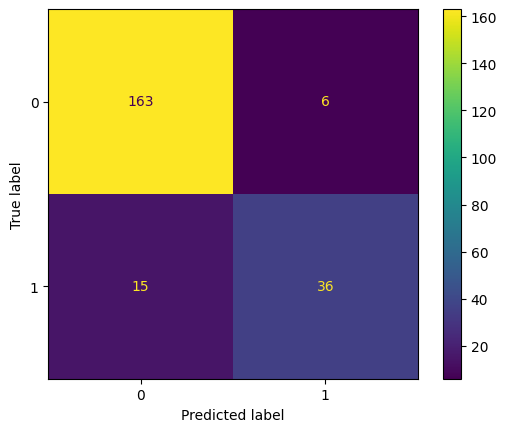

In [608]:
cm = confusion_matrix(y_test, rounded_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [609]:
# ----------------------------
# evaluating with scikit learn metrics
# ----------------------------
acc = accuracy_score(y_test, rounded_predictions)
bac = balanced_accuracy_score(y_test, rounded_predictions)
f1s = f1_score(y_test, rounded_predictions)
print("----------------------------")
print("acc = ", acc)
print("bac = ", bac)
print("f1c = ", f1s)
print("----------------------------")

performances = ([acc, bac, f1s, current_seed, TYPE_OF_IMAGE])
print(performances)
df_performances = pd.DataFrame(performances).transpose()
df_performances.columns = ['accuracy', 'balanced_accuracy', 'fscore', 'seed', 'type_of_image']
df_performances.to_csv(f"performances_cnn_{TYPE_OF_IMAGE}_seed_{current_seed}.csv", index = False)
df_performances.head()

----------------------------
acc =  0.9045454545454545
bac =  0.8351896971806474
f1c =  0.7741935483870968
----------------------------
[0.9045454545454545, np.float64(0.8351896971806474), 0.7741935483870968, 42, 'raw']


,accuracy,balanced_accuracy,fscore,seed,type_of_image
0,0.904545,0.83519,0.774194,42,raw


In [610]:
# -----------------------------------------------------------
# adding predictions to a data frame
# -----------------------------------------------------------

df_x_test_files = pd.DataFrame(x_test_files)
df_pred  = pd.DataFrame(rounded_predictions)
df_label = pd.DataFrame(y_test)
df_merged = pd.concat([df_x_test_files, df_pred, df_label], axis = 1)
df_merged.columns = ['filepath', 'predictions', 'labels']
df_merged.to_csv(f"predictions_cnn_{TYPE_OF_IMAGE}_seed_{current_seed}.csv", index = False)
df_merged.head()

# -----------------------------------------------------------
# -----------------------------------------------------------

,filepath,predictions,labels
0,/content/thermalImagesClassification/data/saud...,0.0,0.0
1,/content/thermalImagesClassification/data/saud...,0.0,0.0
2,/content/thermalImagesClassification/data/saud...,0.0,0.0
3,/content/thermalImagesClassification/data/saud...,1.0,0.0
4,/content/thermalImagesClassification/data/diag...,1.0,1.0


In [611]:
print("Finished !!! :) ")

Finished !!! :) 
